In [1]:
import numpy as np

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
import io
import time
import random

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

!conda install -c conda-forge shapely --yes
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.ops import cascaded_union

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          84 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge


geopy-1.18.1         | 51 KB     | ##################################### | 100% 
geographiclib-1.49   | 32 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

## Package Plan ##

  envi

## 1. Read the json file containing the districts of SF

In [2]:
geolocator = Nominatim()
location = geolocator.geocode('San Francisco, United States of America')
latitude = location.latitude
longitude = location.longitude

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


In [3]:
geo = json.load(open('san-francisco.geojson','r'))
distr=[]
c_points=[]
polygons=[]

for prop in geo['features']:
    for i in range(len(prop['geometry']['coordinates'])):
        points=[]
        
        distr.append( prop['properties']['DISTRICT'] )

        if len(prop['geometry']['coordinates'])<=1:
            coords_=prop['geometry']['coordinates'][i]
        else:
            coords_=prop['geometry']['coordinates'][i][0]
        
        poly=Polygon(coords_)
        polygons.append(poly)    
        c_points.append(poly.centroid.coords[0])

df=pd.DataFrame({'DISTRICT': distr,'center': c_points})
df.head()

,DISTRICT,center
0,CENTRAL,"(-122.40986637030326, 37.79849069540497)"
1,SOUTHERN,"(-122.40167249599693, 37.77981562951606)"
2,SOUTHERN,"(-122.36957296618579, 37.820752443701345)"
3,BAYVIEW,"(-122.3898868766557, 37.73714403652807)"
4,MISSION,"(-122.42263637653645, 37.75756433683498)"


In [4]:
step=10
boundary=cascaded_union(polygons)
bounds=boundary.bounds
dx=(bounds[2]-bounds[0])/step/2
dy=(bounds[3]-bounds[1])/step/2

The shapely package is used to define areas within the city border of SF:

In [5]:
coords=[]
location=[]
temp=[]

for i in range(16):
    for j in range(16):
        temp.append([0.05+i/step,0.05+j/step])

for i in range(len(temp)):
    x=bounds[0]+temp[i][0]*(bounds[2]-bounds[0])
    y=bounds[1]+temp[i][1]*(bounds[3]-bounds[1])
    j=0
    for poly in polygons:
        if poly.contains(Point(x,y)):
                coords.append(Point(x,y))
                location.append(distr[j])
                break
        j=j+1
        

## 2. Use the Foursquare API to find restaurants in SF

In [8]:
import time
LIMIT=30
CLIENT_ID = ''
CLIENT_SECRET = '' 
VERSION = '20180605'

In [9]:
def getNearbyVenues(point_list):
    
    venues_list=[]
    j=0
    for point in point_list:
        sw=[point.y-dy,point.x-dx]
        ne=[point.y+dy,point.x+dx]
        
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent={}&sw={},{}&ne={},{}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            'browse',
            sw[0],sw[1],
            ne[0],ne[1],  
            LIMIT,
            '4d4b7105d754a06374d81259')
        
        results = requests.get(url).json()["response"]['venues']
        
        venues_list.append([(
            j, 
            v['id'],
            v['name'],
            v['location']['lat'],
            v['location']['lng'],
            v['categories'][0]['shortName']) for v in results])
        j=j+1

    print('done')    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['area', 
                  'Venue Id',
                  'Venue Name',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
sf_venues = getNearbyVenues(coords)
#sf_restaurants=pd.read_csv('sf_venues.csv')
sf_restaurants.tail()

,Unnamed: 0,area,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
1484,1484,59,50292c37e4b07a366d3332d0,Above & Beyond Catering,37.757490,-122.387996,Restaurant
1485,1485,60,587fffefd772f95ae76d0d44,Eclectic Cookery,37.728429,-122.365489,Restaurant
1486,1486,60,508e9cb7e4b0661bf61fa066,Sexy Pastries,37.729268,-122.371863,Bakery
1487,1487,60,4fa42275e4b0cbe2df0a8b2a,Taqueria Angelica's,37.727643,-122.368322,Food Truck
1488,1488,60,508e9ba1e4b055a759850961,Beating Those Cakes,37.729268,-122.371863,Bakery


## 3. Clean up the DataFrame

### 3.1 Select Useful Venue Categories

In [20]:
sf_restaurants['area'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [11]:
cat_list=sf_restaurants['Venue Category'].unique()
cat_list

array(['Pizza', 'Coffee Shop', 'Café', 'Sandwiches', 'Tacos', 'Chinese',
       'Food Truck', 'Seafood', 'Food', 'Liquor Store', 'Event Space',
       'Dumplings', 'Fast Food', 'Bakery', 'Mexican', 'Korean', 'Burgers',
       'Diner', 'Food Court', 'Ice Cream', 'American', 'BBQ', 'Indian',
       'Grocery Store', 'Vegetarian / Vegan', 'Brewery', 'Vietnamese',
       'Thai', 'Breakfast', 'Mediterranean', 'Asian', 'Ramen',
       'Middle Eastern', 'Japanese', 'Cafeteria', 'Deli / Bodega',
       'Cantonese', 'Hot Dogs', 'Snacks', 'Bagels', 'Sushi', 'Burritos',
       'Hawaiian', 'Gastropub', 'Bar', 'Italian', 'Bubble Tea',
       'Cupcakes', 'Dim Sum', 'Taiwanese', 'Desserts', 'Donuts',
       'Restaurant', 'Steakhouse', 'New American', 'Southern / Soul',
       'Church', 'Convenience Store', 'Golf Course', 'Poke Place', 'Udon',
       "Farmer's Market", 'Candy Store', 'Juice Bar', 'Greek',
       'North Indian', 'Tea Room', 'Hotpot', 'Toys & Games', 'Ethiopian',
       'Pub', 'Irish', '

In [12]:
invalid_places=['Event Space','Brewery','Church','Golf Course','Poke Place','Butcher',
                'Toys & Games','Cocktail','Tech Startup', 'Karaoke','Bowling Alley','Coworking Space','Skating Rink','Office', 'Non-Profit','Factory']
for place in cat_list:
    if place.find("Bar") > -1 or place.find("Shop") > -1 :
            invalid_places.append(place)
    elif place.find("Store") > -1 or place.find("arket") > -1:
            invalid_places.append(place)

In [13]:
df=sf_restaurants
valid_places= np.setdiff1d(cat_list,invalid_places)
df=df[ df['Venue Category'].isin(  valid_places )]

In [14]:
cat_count=df[['Venue Id','Venue Category']].groupby('Venue Category').count()
cat_count=cat_count.rename(columns={'Venue Id':'Category Count'}).sort_values(by='Category Count', ascending=False)
cat_count.head()

,Category Count
Venue Category,
Café,97
Chinese,80
Bakery,65
Mexican,58
American,47


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64206ccf60>]],
      dtype=object)

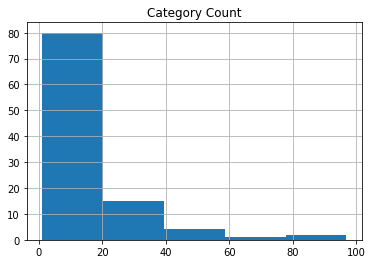

In [55]:
cat_count.hist(bins=5)

### 3.2 Exlude areas that contains too few data points

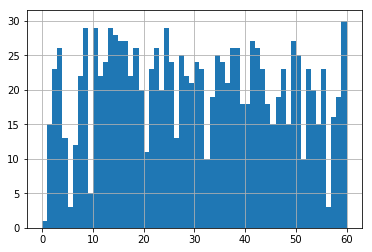

In [16]:
df['area'].hist(bins=max(df['area']),label='Area Count')

As one can see, not all areas have the same amount of venues in them

In [17]:
area_count=df[['area','Venue Category']].groupby('area').count()
area_count=area_count.rename(columns={'Venue Category':'Area Count'}).sort_values(by='Area Count', ascending=False)
lower_bound=area_count['Area Count'].mean()-area_count['Area Count'].std()
lower_bound

13.00262406171137

In [18]:
take_areas=area_count[area_count['Area Count']>=lower_bound].reset_index()
df=df[ df['area'].isin(  take_areas['area'] )]
len(df['area'].unique())

50

We have eliminated all areas, that contain at least 13 locations for further evaluation.

In [21]:
print(df.shape)
df=df.drop(columns=['Unnamed: 0'])
df.head()

(1143, 7)


,area,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
2,1,4b65edd2f964a520f9082be3,Leaping Lemur Café,37.733188,-122.503240,Café
4,1,49cc7e5af964a52084591fe3,Java Beach Cafe,37.735671,-122.503049,Sandwiches
5,1,5c170ddd5f68b9002c632e5c,Underdogs Too,37.741892,-122.504763,Tacos
6,1,58f65b92aa6c9504bfb36af8,Streamline Coffee & Kitchen,37.741859,-122.504548,Café
7,1,4a59b889f964a52084b91fe3,Old Mandarin Islamic Restaurant 老北京,37.738313,-122.500738,Chinese


## 4. Define a dictionary that transforms Venue Categories into integer values

In [22]:
labels=df['Venue Category'].unique()
int_labels={}
str_labels={}
j=0
for v in labels:
    int_labels[v]=j
    str_labels[j]=v
    j=j+1

In [35]:
df2=df.copy()
df2['Venue Category']=df2['Venue Category'].map(int_labels)
df2.head()

,area,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
2,1,4b65edd2f964a520f9082be3,Leaping Lemur Café,37.733188,-122.503240,0
4,1,49cc7e5af964a52084591fe3,Java Beach Cafe,37.735671,-122.503049,1
5,1,5c170ddd5f68b9002c632e5c,Underdogs Too,37.741892,-122.504763,2
6,1,58f65b92aa6c9504bfb36af8,Streamline Coffee & Kitchen,37.741859,-122.504548,0
7,1,4a59b889f964a52084b91fe3,Old Mandarin Islamic Restaurant 老北京,37.738313,-122.500738,3


In [4]:
#df.to_csv('venues_cleaned.csv')
df=pd.read_csv('venues_cleaned.csv')

,Unnamed: 0,area,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,207,11,56343465498e0e6662abacc3,Fei Kitchen,37.718004,-122.474208,Chinese
1,340,15,4b636f17f964a52083792ae3,Irving Subs,37.763965,-122.469471,Sandwiches
2,761,31,5127a9e2183f56cf2d7bfe9a,Chubby Noodle,37.799653,-122.437957,Noodles
3,929,38,583638538d8e9962925c86fe,Hinodeya Ramen Bar,37.786223,-122.429956,Ramen
4,292,14,4a56c167f964a520c1b51fe3,Noriega Teriyaki House,37.753931,-122.482702,Japanese


## 5. Get the likes and users of each restaurant

In [23]:
def get_Likes(venues_id):
    like_list=[]

    for id in venues_id['Venue Id']:
    
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
           id,
           CLIENT_ID, 
           CLIENT_SECRET, 
           VERSION
         )
        results = requests.get(url).json()["response"]
        if bool(results):
        
            results = results['likes']
            user_likes=[]
            if 'items' in results:
                for v in results['items']: 
                    user_likes.append(v['id'])
                
            like_list.append([(
                id, 
                results['count'],
                ','.join([str(x) for x in user_likes]),
                )])
        else:
            break

    print('done')    
    likes_df = pd.DataFrame([item for venue_list in like_list for item in venue_list])
    likes_df.columns = ['Venue Id',
                'Like Count',
                   'Users']
    
    return(likes_df)

In [24]:
#likes_df=get_Likes(df)
likes_df=pd.read_csv('likes_df.csv')
likes_df.shape

(1142, 5)

In [44]:
df2=df.merge(likes_df,on='Venue Id')
df2.head()

,area,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category,Unnamed: 0,Unnamed: 0.1,Like Count,Users
0,1,4b65edd2f964a520f9082be3,Leaping Lemur Café,37.733188,-122.503240,Café,243,243,18,"59655,61105173,3202140"
1,1,49cc7e5af964a52084591fe3,Java Beach Cafe,37.735671,-122.503049,Sandwiches,934,934,122,"444299,20996810,74343449"
2,1,5c170ddd5f68b9002c632e5c,Underdogs Too,37.741892,-122.504763,Tacos,195,195,1,69868
3,1,58f65b92aa6c9504bfb36af8,Streamline Coffee & Kitchen,37.741859,-122.504548,Café,161,161,24,"972896,20459137,31716"
4,1,4a59b889f964a52084b91fe3,Old Mandarin Islamic Restaurant 老北京,37.738313,-122.500738,Chinese,112,112,138,"47621,84357752,47985968"


In [45]:
df2.shape

(1142, 10)

## 6. Cluster the data and plot the average likes per area

In [80]:
like_count_temp=df2[['area','Venue Category','Like Count']].copy()
like_count_temp.sort_values(by=['Like Count']).tail()

,area,Venue Category,Like Count
679,36,Beer Garden,1914
1043,54,Burgers,1935
896,46,Gastropub,1974
674,36,Bakery,2220
683,36,Ice Cream,2223


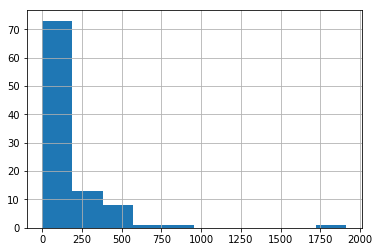

In [81]:
like_count_temp=like_count_temp[['Venue Category','Like Count']].groupby('Venue Category').mean().sort_values(by=['Like Count'])
like_count_temp['Like Count'].hist()

In [29]:
like_count_temp['Like Count']=like_count_temp['Like Count']/max(like_count_temp['Like Count'])
like_count_temp=like_count_temp.reset_index()
likes_by_cat=like_count_temp.sort_values(by=['Like Count'])
likes_by_cat.head()

,Venue Category,Like Count
0,Fondue,0.000000
1,Food,0.000076
2,Snacks,0.000522
3,Middle Eastern,0.000522
4,Bistro,0.000522


In [84]:
likes_by_area=df2[['area','Like Count']].groupby('area').mean().sort_values(by=['Like Count'])
likes_by_area['Like Count']=likes_by_area['Like Count']/max(likes_by_area['Like Count'])
likes_by_area_dict=likes_by_area.to_dict()
likes_by_area=likes_by_area.reset_index()

In [10]:
likes_by_area.head()

,area,Like Count
0,57,0.000085
1,40,0.001820
2,17,0.001862
3,58,0.001940
4,11,0.005088


In [85]:
str1='{"type": "FeatureCollection","crs": {"type": "name","properties": {"name": "sf_polygons"}}, "features": ['                                                                 
geo_string=[]
j=0
for r in coords:
    if j in likes_by_area['area'].unique():
        geo_string.append( '{ "type": "Feature", "properties": { "area": '+str(j)+' }, "geometry": { "type": "Polygon", '+
                       '"coordinates": [' + str([[r.x+dx,r.y+dy],[r.x+dx,r.y-dy],[r.x-dx,r.y-dy],[r.x-dx,r.y+dy],[r.x+dx,r.y+dy]])
                       + '] } }')
    j=j+1
geo2=str1+','.join(geo_string)+']}'

In [18]:
sf_map = folium.Map(location=[latitude, longitude], zoom_start=12)
sf_map.choropleth(
    geo_data=geo2,    
    fill_color='YlOrRd',
    name='choropleth',
    data=likes_by_area,
    columns=['area','Like Count'],
    key_on='feature.properties.area',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average like count of restaurants/a.u.'
)

sf_map

In [ ]:
from folium.features import DivIcon
for r in df2['area']:
    p= coords[r]
    folium.map.Marker(
    [p.y, p.x],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt">'+str(r)+'</div>',
        )
    ).add_to(sf_map)

In [ ]:
sf_map

## 7. Compare least liked and most liked catergory per area

In [87]:
temp=df2[['area','Venue Category','Like Count']].sort_values(['area','Venue Category'])
temp=temp.groupby(['area','Venue Category']).mean()
temp=temp.reset_index()

l_likes=[]
m_likes=[]
for area in np.unique(temp['area'].values):
    m=temp[ temp['area']==area]
    m_likes.append( ','.join(m[m['Like Count']==max(m['Like Count'])]['Venue Category'].values))
    l_likes.append( ','.join(m[m['Like Count']==min(m['Like Count'])]['Venue Category'].values))   
    
minMax_df=pd.DataFrame({'area': np.unique(temp['area'].values), 'Least liked': l_likes, 'Most liked': m_likes,  })

In [88]:
minMax_df.set_index(['Most liked','area']).sort_values(['Most liked']).head(10)

Least liked
Most liked area                                                   
African    50    Bakery,Cajun / Creole,Desserts,Food,Restaurant...
American   3        BBQ,Bakery,Food,Food Truck,Japanese,Sandwiches
Asian      57    Bakery,Deli / Bodega,Food,Gourmet,Restaurant,S...
Bakery     36                                                Salad
           2     American,BBQ,Diner,Food,Food Court,Food Truck,...
           30                                BBQ,Restaurant,Snacks
Breakfast  48    Bakery,Chinese,Food,Restaurant,Seafood,Tacos,V...
           52                                              Burgers
Bubble Tea 10                                                Pizza
Burgers    47                                               Donuts

## 8. Use  LogisticRegression to predict if the like count as a function of location and catergory

In [203]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report

import itertools

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline

In [138]:
cluster_df=df2[['Venue Latitude','Venue Longitude','area','Venue Category','Like Count']]
cluster_df['Venue Category']=cluster_df['Venue Category'].map(int_labels)
cluster_df['Like Count']=cluster_df['Like Count']/max(cluster_df['Like Count'])
cluster_df.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Venue Latitude,Venue Longitude,area,Venue Category,Like Count
0,37.733188,-122.503240,1,0,0.008097
1,37.735671,-122.503049,1,1,0.054881
2,37.741892,-122.504763,1,2,0.000450
3,37.741859,-122.504548,1,0,0.010796
4,37.738313,-122.500738,1,3,0.062078


In [228]:
X=cluster_df[['Venue Latitude','Venue Longitude','Venue Category']]
X=preprocessing.StandardScaler().fit(X).transform(X)
y= np.around(df2['Like Count'].values/max(df2['Like Count']) +0.4 )

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [229]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 916, 1.0: 226}

In [230]:
LR = LogisticRegression(C=0.1, solver='lbfgs').fit(X_train,y_train)
LR

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [231]:
yhat = LR.predict(X_test)
jaccard_similarity_score(y_test, yhat)

0.777292576419214

In [232]:
print (classification_report(y_test, yhat))


              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87       183
         1.0       0.38      0.17      0.24        46

   micro avg       0.78      0.78      0.78       229
   macro avg       0.60      0.55      0.55       229
weighted avg       0.73      0.78      0.74       229

